# T012 · Data acquisition (PubChem)

Authors:

- Jaime Rodríguez-Guerra, 2019-2020, [Volkamer lab, Charité](https://volkamerlab.org/)
- Dominique Sydow, 2019-2020, [Volkamer lab, Charité](https://volkamerlab.org/)

## Aim of this talktorial

We will search based on an input SMILES for similar compounds in PubChem.

### Contents in *Theory*

- PubChem

### Contents in *Practical*

- Write the functions that will compose the pipeline
- Case study: EGFR inhibitors

## References

* PubChem, a small compound database ([_Nucleic Acids Res._ (2019), __47__, D1102-1109](https://academic.oup.com/nar/article/47/D1/D1102/5146201))

## Theory

**WIP! Update!** Based on ligand information, we can query PubChem for similar compounds.

### PubChem

* Role: Small compounds database
* Website: https://pubchem.ncbi.nlm.nih.gov/
* API: Yes, REST-based. No official client. Use `bravado`.
* Documentation: https://pubchemdocs.ncbi.nlm.nih.gov/pug-rest
* Literature:
    * [_Nucleic Acids Res._ (2019), __47__, D1102-1109](https://academic.oup.com/nar/article/47/D1/D1102/5146201)

> PubChem is an open chemistry database at the National Institutes of Health (NIH). “Open” means that you can put your scientific data in PubChem and that others may use it. Since the launch in 2004, PubChem has become a key chemical information resource for scientists, students, and the general public. Each month our website and programmatic services provide data to several million users worldwide.

## Practical

**TODO** Explain what happens in the "Practical" section.

### Query PubChem

Use the a `SMILES` string to query similar compounds in PubChem.

> Tip: You can check [Talktorial T1](https://github.com/volkamerlab/TeachOpenCADD/blob/master/talktorials/1_ChEMBL/T1_ChEMBL.ipynb) to see how to do a similar operation with ChEMBL database.

In [1]:
import time
import requests
from urllib.parse import quote


def similar_compounds_pubchem(smiles, threshold=75, n_records=10):
    # Query PubChem for similar compounds
    escaped_smiles = quote(smiles).replace("/", ".")
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/similarity/smiles/{escaped_smiles}/JSON?Threshold={threshold}&MaxRecords={n_records}"
    r = requests.get(url)
    r.raise_for_status()
    key = r.json()["Waiting"]["ListKey"]
    # Response is async, poll every second for 25 seconds to see if it's done
    attempts = 25
    while attempts:
        r = requests.get(
            f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/listkey/{key}/cids/JSON"
        )
        r.raise_for_status()
        response = r.json()
        if "IdentifierList" in response:
            cids = response["IdentifierList"]["CID"]
            break
        attempts -= 1
        time.sleep(1)
    else:
        raise IOError("Could not find matches for " + smiles)
    # We get the Compound IDs back, but we need the SMILES
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{','.join(map(str, cids))}/property/CanonicalSMILES/JSON"
    r = requests.get(url)
    r.raise_for_status()
    return [item["CanonicalSMILES"] for item in r.json()["PropertyTable"]["Properties"]]

In [2]:
def query_pubchem_for_similar_compounds(ligands):
    # Get the first ligand for the current kinase
    smiles = ligands[0]
    # Look for 10 most similar compounds on pubchem
    return similar_compounds_pubchem(smiles, n_records=10)

In [3]:
import nglview as nv
from tempfile import NamedTemporaryFile
from rdkit import Chem
from rdkit.Chem.Draw import (
    IPythonConsole,
    MolsToGridImage,
)  # Needed to show molecules

def preview_smiles(smiles):
    print(smiles)
    return Chem.MolFromSmiles(smiles)


def multi_preview_smiles(*smiles):
    legends = [f"{s[:30]}..." for s in smiles]  # shorten the smiles string to avoid text overlap
    molecules = [Chem.MolFromSmiles(s) for s in smiles]
    return MolsToGridImage(
        molecules,
        molsPerRow=3,
        subImgSize=(300, 300),
        maxMols=len(molecules),
        legends=legends,
        useSVG=True,
    )

**TODO** Set query SMILES (these where before the output of the KLIFS query - think of a better ligand set, maybe all kinase inhibitors for EGFR?

In [4]:
ligands = [
    'O=C(O)C=1N(c2c(c(ncc2)c3c4c(ccc3)cccc4)C1)CC5=NOC(=N5)c6ccccc6',
    'Clc1c(nc(nc1)N[C@H](c2ncc(F)cc2)C)NC=3NN=C(OC(C)C)C3',
    'S1C(=NC=C1)c2cc(ccc2)CN(C(=O)Nc3ccc(OC(F)(F)F)cc3)C4CC4',
    'Fc1cc(ccc1)[C@@H]2N(C3=NN4C(=NC=C4c5ncccc5)C=C3)CCC2',
    'O1CCN(c2ccc(Nc3ncnc4c3nc(NCc5cnccc5)cc4)cc2)CC1',
    'Fc1cc(ccc1)[C@H]2N(C3=NN4C(=NC=C4c5ccc(C#N)cc5)C=C3)CCOC2',
    'O=C(NC=1N(N=C(C1)C2CC2)c3ccccc3)CN4N=NC(c5cc(OC)c(N6C=NC(=C6)C)cc5)=C4',
    'Fc1cc(F)cc(c1)Cc2cc3c(N=NC3=NC(=O)c4c(NC5CCOCC5)cc(N6CCN(CC6)C)cc4)cc2',
    'O=C(Nc1ncccc1)Nc2c(nc(nc2)C)c3ccccc3',
    'O=C(Nc1c(nc(nc1)C)c2ccccc2)NC3c4c(c5c3cccc5)cccc4',
    'O=C(Nc1c(nc(nc1)C)c2ccccc2)Nc3c4c(ccc3)cccc4',
    'FC(F)(F)c1c(cccc1)CNC(=O)Nc2c(nc(nc2)C)c3ccccc3',
    'FC(F)(F)c1c(cccc1)CNC(=O)NC=2C(=NOC2C)c3ccccc3',
    'S1C(C=2N(c3c(cccc3)C2)CC(=O)NCc4ncccc4)=CC=C1'
]

Draw the query compounds with RDKit

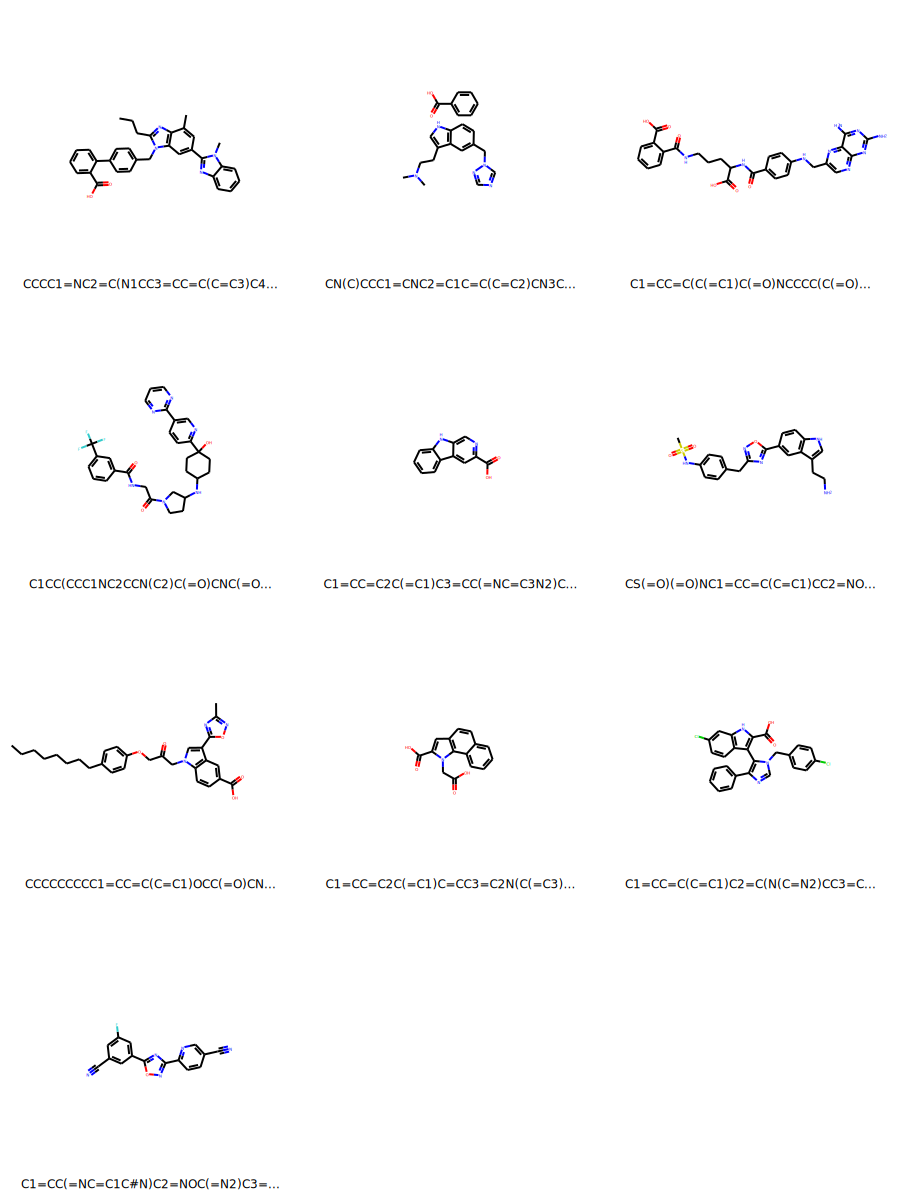

In [5]:
similar_smiles = query_pubchem_for_similar_compounds(ligands)
multi_preview_smiles(*similar_smiles)

## Discussion

**TODO** Update! Remove KLIFS mentions.

In this notebook you have learned how to access and use different web services depending on the technologies available, from well documented API to handcrafted scrapers that try to mimic an actual web browser.

So far, we have queried the KLIFS database for members of the EGFR family, obtaining a kinase structure plus (unsurprisingly) its native ligand, the ATP. Then, PubChem has provided similar compounds with more than a 75% of similarity. We will choose one of those to perform structural modeling in the next parts.


## Quiz

- **TODO**
- Can you make the similarity search more strict?
- Is any of the proposed candidates already an approved inhibitor? (Hint: You can _scrape_ [PKIDB](http://www.icoa.fr/pkidb/) and check against the list of smiles)